# Basic Usage of the Uncertainty Characteristics Curve (UCC)
Needs `uncertainty_characteristics_curve.py` and `sample_predict.pkl` files to be in the same directory.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from uq360.metrics.uncertainty_characteristics_curve import UncertaintyCharacteristicsCurve as ucc
from copy import deepcopy

In [28]:
import pickle
# This is a file with sample timeseries data provided along with this notebook.  
D = pickle.load(open('sample_predict.pkl','rb'))

In [29]:
def form_D(yhat, zhatl, zhatu):
    # a handy routine to format data as needed by the UCC fit() method
    D = np.zeros([yhat.shape[0],3])
    D[:, 0] = yhat
    D[:, 1] = zhatl
    D[:, 2] = zhatu
    return D

## First a super short example of the essential functionality
Exercised methods: `fit(), plot_UCC()`

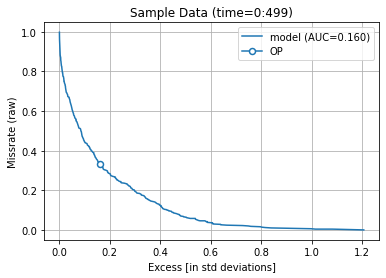

AUUCC is 0.16, OP = (0.24, 0.33)


In [30]:
%matplotlib inline
take_from = 0  # take samples from this time index
take_to = 500  # to this index
pred = D['pred'][take_from: take_to]  # target predictions
actual = D['actual'][take_from: take_to]   # ground truth observations
lb = D['lb'][take_from: take_to]   # lower bound of the prediction interval 
ub = D['ub'][take_from: take_to]  # upper bound of the prediction interval 
z = range(take_from, take_to)
bwl = pred - lb   # lower band (deviate) 
bwu = ub - pred   # upper band (deviate)

# form matrix for ucc:
X = form_D(pred, bwl, bwu)

# create an instance of ucc and fit data
u = ucc()
u.fit(X, actual)

# plot the UCC, show the AUUCC, and the OP:
auucc, op_info = u.plot_UCC(titlestr=('Sample Data (time=%d:%d)' % (np.min(z), np.max(z))))
print("AUUCC is %.2f, OP = (%.2f, %.2f)" % (auucc, op_info[0]/op_info[2], op_info[1]))

## Select axes as desired
Possible axes types: {missrate, excess, deficit, bandwidth} and individual axes can also be set to use of {raw, stddev} units. 
Exercised methods: `set_coordinates(), plot_UCC()`

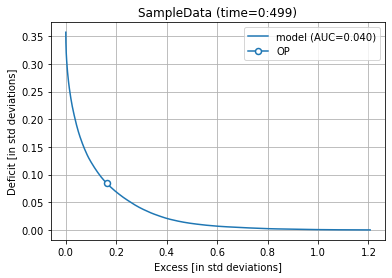

AUUCC is 0.04, OP = (0.24, 0.08)


In [31]:
# Switch axes: 
u.set_coordinates(x_axis_name='excess', y_axis_name='deficit', normalize=True)
auucc, op_info = u.plot_UCC(titlestr=('SampleData (time=%d:%d)' % (np.min(z), np.max(z)) ))
print("AUUCC is %.2f, OP = (%.2f, %.2f)" % (auucc, op_info[0]/op_info[2], op_info[1]))


## Just get the Area Under Curve
If you don't care about the plotting business..

Exercised methods: `get_AUUCC()`

In [32]:
# If you just need the AUC
auucc = u.get_AUUCC()
print("AUUCC is %.2f" % auucc)

AUUCC is 0.04


### Partial AUC can also be calculated
Partial AUC can help a comparison of models in a narrower operating _range_. A user can constrain the area by specifying an interval (from, to) on either the x-axis or on the y-axis. 

In [33]:
# suppose your application focuses on very low deficit (on other examples it might be a very low Miss Rate)
# get a partial area under the UCC curve for deficit <= 0.05
print("Low-Deficit AUUCC is %.3f" % u.get_AUUCC(partial_y=(0., 0.05)))

Low-Deficit AUUCC is 0.008


In [34]:
# similarly we can limit the AUC calculation by the x axis:
print("Low-Excess AUUCC is %.3f" % u.get_AUUCC(partial_x=(0., 0.1)))

Low-Excess AUUCC is 0.019


Note that the interval values apply on the axes as displayed, incl. any normalization currently active. 

In [35]:
# If you prefer to have coordinates with raw units uncomment:
# u.set_coordinates(normalize=False)
# If you prefer to set normalization for just one coordinate (but we don't recommend it):
# u.set_coordinates(x_axis_name='excess', normalize=False)

## Minimize a linear cost function
Is there a better Operating Point for my error bars?

Exercised methods: `minimize_cost()`

In [36]:
# optimize linear cost function 
C = u.minimize_cost(x_axis_cost=1., y_axis_cost=10.)
print(C)

INFO(UCC): Pre-norming costs by corresp. std deviation: new x_axis_cost = 1.4901, y_axis_cost = 14.9012
{'operation': 'bias', 'cost': 0.5848808049662977, 'modvalue': 0.2321991695276715, 'new_x': 0.29450969736285865, 'new_y': 0.009799569932390551, 'original_cost': 1.0046802066967786}


Note that by default the costs factors (1. and 10.) will be adjusted (divided) by the standard deviation used by the axes setting (as applicable) to achieve the desired proportion as visualised on the normed axes. An INFO message will be printed, as above. This default behavior can be disabled by setting `augment_cost_by_normfactor=False` in the `minimize_cost` call above. 

Note that by default the UCC determines the minimum cost by search over two calibration operations supported: 'scale' and 'bias' (additive shift of prediction intervals). The return object will contain the information which operation lead to the optimum. This behavior can be adjusted by the option `search` followed by a list of at least one of `scale` and `bias`. For example, limiting the minimization to the scaling calibration we can write:

In [37]:
C = u.minimize_cost(x_axis_cost=1., y_axis_cost=10., search=['scale'])

INFO(UCC): Pre-norming costs by corresp. std deviation: new x_axis_cost = 1.4901, y_axis_cost = 14.9012


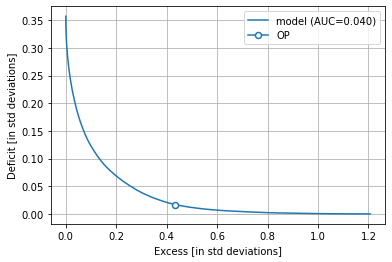

In [38]:
# interpreting the above outcome: we can improve the original OP cost ('original_cost') to a new OP cost ('cost') 
# by performing operation C['operation'] (either 'scale' or 'bias') with a value
# C['modvalue'] to the original bars:
X2 = deepcopy(X)
if C['operation'] == 'bias':
    X2[:, 1:] += C['modvalue']
else:
    X2[:, 1:] *= C['modvalue']        
u.fit(X2, actual)
auucc, op_info = u.plot_UCC()

## The UCC Class handles multiplicity of Inputs 
If user provides input data as a `list` corresponding to multiple systems of error bars, all UCC's methods will return `list` of corresponding results. 

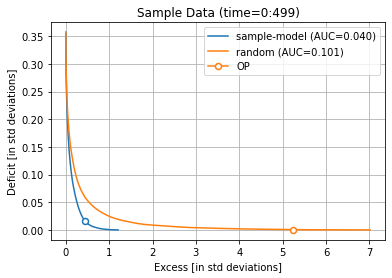

AUUCC is 0.04, OP = (0.65, 0.03)
AUUCC is 0.10, OP = (7.80, 0.00)


In [39]:
# finally,if you want to plot multiple systems:
# as an example, create a second set of bars that are simply random
r = np.random.uniform(low=.1*np.mean(X[:,0]), high=2*np.mean(X[:,0]), size=[len(X[:,0],)])
Xrand = form_D(pred, r, r)
# and plot
u.fit([X2, Xrand], actual)
auuccl, op_infol = u.plot_UCC(syslabel=['sample-model', 'random'], titlestr=('Sample Data (time=%d:%d)' % (np.min(z), np.max(z)) ))
# note that results are now lists
for auucc, op_info in zip(auuccl, op_infol):
    print("AUUCC is %.2f, OP = (%.2f, %.2f)" % (auucc, op_info[0]/op_info[2], op_info[1]/op_info[3]))

## Use non-default additive bias as the UCC varying paramater
By default, the UCC is produced by varying a multiplicative scale applied to the error bars. The UCC class also supports varying additive bias. Switching to bias will lead to different UCC curves (although for most well-behaved problems, additive bias and multiplicative scales tend to produce comparable shapes and rankings of systems). 
Use option `vary_bias=True` to use the additive bias. Default is `False` (multiplicative scale)

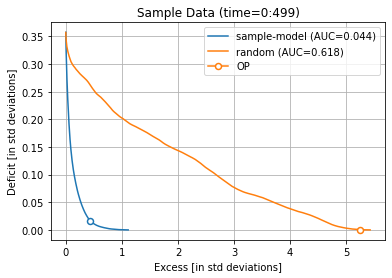

AUUCC is 0.04, OP = (0.65, 0.03)
AUUCC is 0.62, OP = (7.80, 0.00)


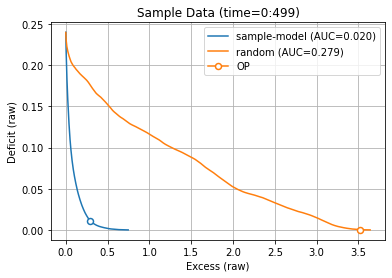

AUUCC is 0.02, OP = (0.29, 0.01)
AUUCC is 0.28, OP = (3.51, 0.00)


In [40]:
# it is easy to plot same UCC but using additive bias:
# Btw, no need to call fit() again as the bias-related values have been precomputed with previous fit() calls
# u.fit(X, actual)
u.set_coordinates(normalize=True)   # this is the default, just making sure
auucc, op_info = u.plot_UCC(syslabel=['sample-model', 'random'], titlestr=('Sample Data (time=%d:%d)' % (np.min(z), np.max(z)) ),vary_bias=True)
for auucc, op_info in zip(auucc, op_info):
    print("AUUCC is %.2f, OP = (%.2f, %.2f)" % (auucc, op_info[0]/op_info[2], op_info[1]/op_info[3]))
    
# and one can change the normalization behavior of the axes (sticky)
u.set_coordinates(normalize=False)
auucc, op_info = u.plot_UCC(syslabel=['sample-model', 'random'], titlestr=('Sample Data (time=%d:%d)' % (np.min(z), np.max(z)) ),vary_bias=True)
for auucc, op_info in zip(auucc, op_info):
    print("AUUCC is %.2f, OP = (%.2f, %.2f)" % (auucc, op_info[0]/op_info[2], op_info[1]/op_info[3]))


## Get a specific operating point on an existing curve
User wishes to determine value y (x), given a value x (y) 
Exercised methods: `get_specific_operating_point()`

In [41]:
# one get y value for any x value, and vice versa (on bias varying plot)
print(u.get_specific_operating_point(req_x_axis_value=0.3, vary_bias=True))

[{'operation': 'bias', 'modvalue': 0.008458086193544934, 'new_x': 0.29887737399514175, 'new_y': 0.010600718832063599}, {'operation': 'bias', 'modvalue': -5.089425161183115, 'new_x': 0.3040587447906394, 'new_y': 0.17406152697757582}]


So, the corresponding value to our (given) x=0.3 is `new_y` (0.009..). But wait! We also added a recipe how to get to this OP from your original OP that you used when calling the `fit()` method, all for free: add (`bias`) of `modvalue` (0.233..) .. to your bands and you will get there (on a bias-based plot).

Similar logic applies to the other curves listed in the resulting array...

In [42]:
# similarly for scale, if we work with scale-based plots:
print(u.get_specific_operating_point(req_x_axis_value=3.0, vary_bias=False))

[{'operation': 'scale', 'modvalue': 2.0198247707672152, 'new_x': 0.8100363351823487, 'new_y': 0.0}, {'operation': 'scale', 'modvalue': 0.8774650038332056, 'new_x': 3.054370489798178, 'new_y': 0.0008086561851187653}]


-> in this case we have to multiply (`scale`) our bands by 3.4531.. (`modvalue`)

# More elaborate example of analysis

In [43]:
# reload
pred = D['pred']
actual = D['actual']
lb = D['lb']
ub = D['ub']
bwl = pred - lb   # bandwidth lower
bwu = ub - pred   # bandwidth upper

## Get the UCC on a sample subsequence and assess

### This is how the original uncertainty band looks like

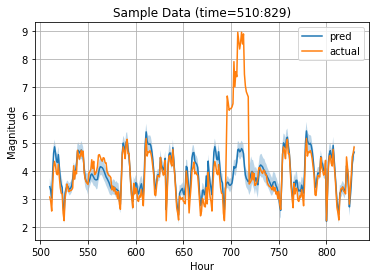

In [44]:
plt.figure()
z = range(510,830)  # take a small time window
plot_lb = pred - bwl
plot_ub = pred + bwl
p = plt.plot(z, pred[z], label='pred')
plt.plot(z, actual[z], label='actual')
plt.fill_between(z, plot_lb[z], plot_ub[z] ,alpha=0.3, facecolor=p[0].get_color())
plt.xlabel('Hour')
plt.ylabel('Magnitude')
plt.title('Sample Data (time=%d:%d)' % (np.min(z), np.max(z)) )
plt.legend()
plt.grid()

### and its corresponding UCC:

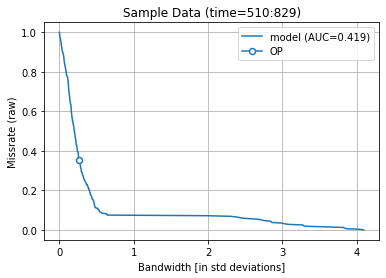

INFO: AUUCC=0.4188, Wband=0.2632, MissRate=0.3531
INFO: Cost(1.0000*Wband+10.0000*Mrate) = 3.7945


In [45]:
Cwband = 1   # Cost of one unit of bandwidth
Cmiss = 10   # Cost of one miss
x = pred[z]
t = actual[z]    # Ground truth
X = form_D(x, bwl[z], bwu[z])
u = ucc()
u.fit(X, t)
u.set_coordinates(x_axis_name = 'bandwidth', y_axis_name = 'missrate', normalize=True)
auucc, op_info = u.plot_UCC(titlestr=('Sample Data (time=%d:%d)' % (np.min(z), np.max(z)) ))
print("INFO: AUUCC=%.4f, Wband=%.4f, MissRate=%.4f" % (auucc, op_info[0], op_info[1]))
print("INFO: Cost(%.4f*Wband+%.4f*Mrate) = %.4f" % (Cwband, Cmiss, Cwband*op_info[0]+Cmiss*op_info[1]))


In [46]:
C = u.minimize_cost(x_axis_cost=Cwband, y_axis_cost=Cmiss, search=['scale'])
print(C)

INFO(UCC): Pre-norming costs by corresp. std deviation: new x_axis_cost = 0.8495, y_axis_cost = 10.0000
{'operation': 'scale', 'cost': 1.3932097087057027, 'modvalue': 2.443731977029287, 'new_x': 0.7571425696363236, 'new_y': 0.07499999999999996, 'original_cost': 3.79445796010028}


The system operates at 35% Miss Rate. The uncertainty band may be unnecessarily narrow!
We could move the operating point to exploit the sharp bend in the curve to obtain a better OP.

The sharp bend point looks like a good candidate for an optimum point, let's see whether that's true

### Modified uncertainty band:

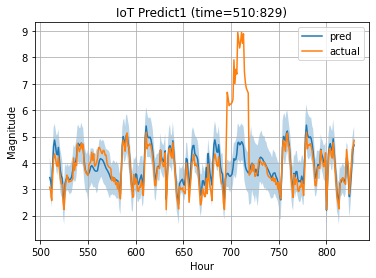

In [47]:
new_scale = C['modvalue']
if C['operation']=='bias':
    plot_lb = pred - (bwl + new_scale)
    plot_ub = pred + (bwl + new_scale)
else:
    plot_lb = pred - (bwl * new_scale)
    plot_ub = pred + (bwl * new_scale)
plt.figure()
p = plt.plot(z, pred[z], label='pred')
plt.plot(z, actual[z], label='actual')
plt.fill_between(z, plot_lb[z], plot_ub[z] ,alpha=0.3, facecolor=p[0].get_color())
# plt.plot(z, 0.5* abn[z]+1.5, label='abn')
plt.xlabel('Hour')
plt.ylabel('Magnitude')
plt.title('IoT Predict1 (time=%d:%d)' % (np.min(z), np.max(z)) )
plt.legend()
plt.grid()

### and its corresponding UCC:

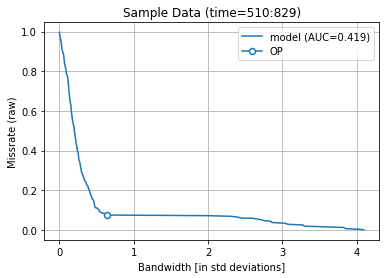

INFO: AUUCC=0.4193, Wband=0.6432, MissRate=0.0750
INFO: Cost(1.0000*Wband+10.0000*Mrate) = 1.3932


In [48]:
%matplotlib inline
from copy import deepcopy
x = pred[z]
t = actual[z]
Xnew = deepcopy(X)
Xnew[:,0] = x    #
if C['operation']=='bias':
    Xnew[:,1] = new_scale + bwl[z]   # lower bound width
    Xnew[:,2] = new_scale + bwu[z]   # Upper bound width
else:    
    Xnew[:,1] = new_scale * bwl[z]   # lower bound width
    Xnew[:,2] = new_scale * bwu[z]   # Upper bound width
u.fit(Xnew, t)
auucc, op_info = u.plot_UCC(titlestr=('Sample Data (time=%d:%d)' % (np.min(z), np.max(z)) ))
print("INFO: AUUCC=%.4f, Wband=%.4f, MissRate=%.4f" % (auucc, op_info[0], op_info[1]))
print("INFO: Cost(%.4f*Wband+%.4f*Mrate) = %.4f" % (Cwband, Cmiss, Cwband*op_info[0]+Cmiss*op_info[1]))

After widening the uncertainty band corresponding to the new operating point the Miss Rate is reduced from 35% to 10%, while still preserving the apparent true anomaly, as shown in the above time series plot.